# Question 1

[0.         0.03346043 0.07200965]
[0.00021894 0.06491373 0.13739986]
[0.00065899 0.09451428 0.19689535]
[0.001314   0.12242329 0.25120627]
[0.00217284 0.1487977  0.30098491]
[0.00322179 0.17378387 0.34680805]
[0.00444629 0.19751483 0.38917464]
[0.00583184 0.22010964 0.42851143]
[0.00736463 0.24167395 0.46518157]
[0.00903176 0.26230116 0.49949384]


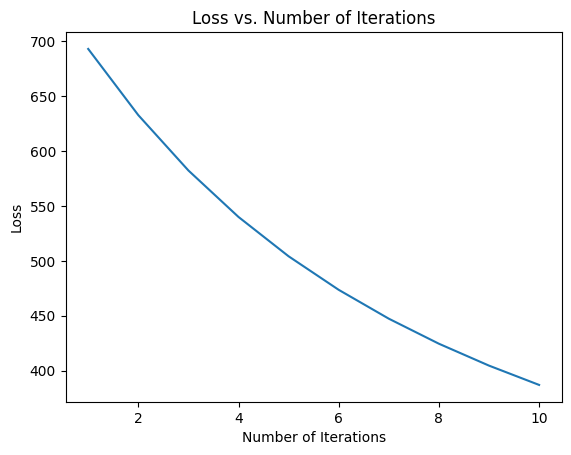

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate synthetic data
np.random.seed(0)
centers = [[-5, 0], [0, 1.5]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

# Add a bias term to the feature matrix
X = np.c_[np.ones((X.shape[0], 1)), X]

# Initialize coefficients
W = np.zeros(X.shape[1])

# Define the logistic sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define the logistic loss (binary cross-entropy) function
def log_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip to avoid log(0)
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Gradient descent and Newton method parameters
learning_rate = 0.1
iterations = 10
loss_history = []

for i in range(iterations):
    # Calculate predicted probabilities
    z = np.dot(X, W)
    y_pred = sigmoid(z)

    # Calculate and record the current loss
    loss = log_loss(y, y_pred)
    loss_history.append(np.sum(loss))

    # Calculate the gradient based on the provided formula
    N = len(y)
    gradient = np.dot(np.ones(N).T, (np.dot(np.diag(y_pred - y), X)))
    W = W - learning_rate * (1/N) * gradient
    print(W)
# Plot the loss function with respect to the number of iterations
plt.plot(range(1, iterations+1), loss_history)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Iterations')
plt.show()


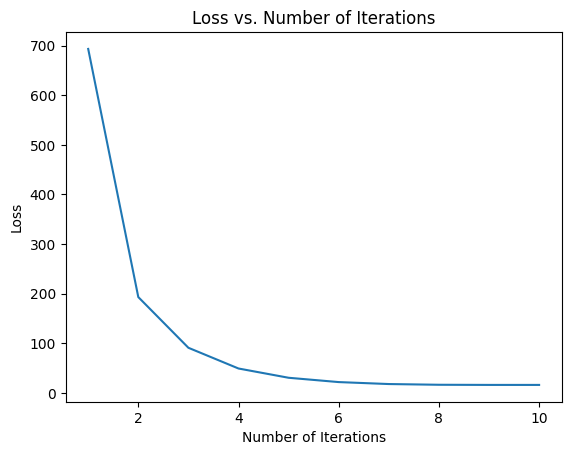

In [116]:
loss_history1 = []
W = np.zeros(X.shape[1])
for i in range(iterations):
    # Calculate predicted probabilities
    z = np.dot(X, W)
    y_pred = sigmoid(z)

    # Calculate and record the current loss
    loss = log_loss(y, y_pred)
    loss_history1.append(np.sum(loss))

    # Calculate the gradient based on the provided formula
    N = len(y)
    si = (y_pred-y)*(1-y_pred-y)
    S = np.diag(si)
    gradient = np.dot(np.ones(N).T, (np.dot(np.diag(y_pred - y), X)))
    hessian = np.dot(X.T, np.dot(S,X))
    W = W -  np.dot(np.linalg.inv((1/N)*hessian), (1/N) * gradient)
    

# Plot the loss function with respect to the number of iterations
plt.plot(range(1, iterations+1), loss_history1)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Iterations')
plt.show()

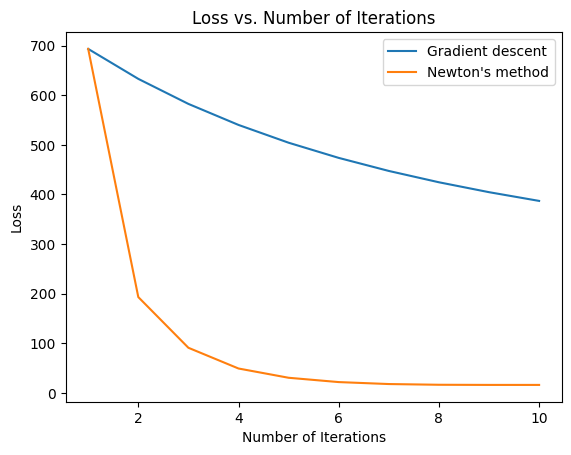

In [117]:
plt.plot(range(1, iterations+1), loss_history, label ="Gradient descent")
plt.plot(range(1, iterations+1), loss_history1, label = "Newton's method")
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Iterations')
plt.legend()
plt.show()

# Question 2

Best parameter (CV score=0.924):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 60}


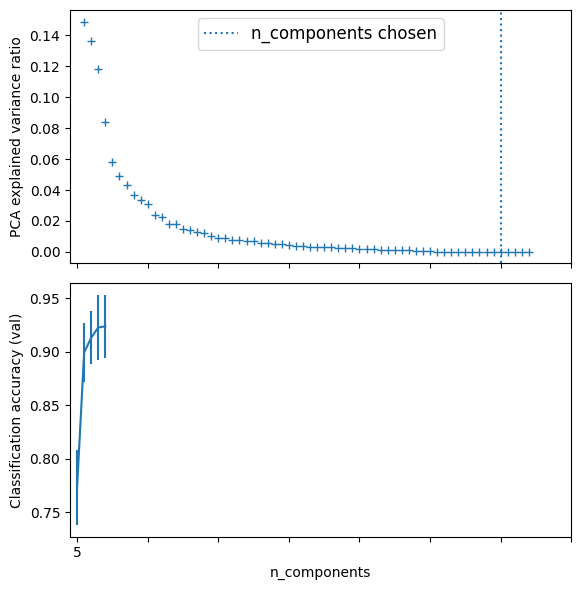

In [129]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import check_random_state

# Data loading
train_samples = 500
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=100)
print(X_train)



URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1002)>